In [1]:
from rethon.numpy_implementation import BDDNumpyDialecticalStructure, NumpyPosition
from remodeldescription.basics import Position
from dd.autoref import BDD
from typing import Set, Iterator, List
import numpy as np

from rethon.model import StandardPosition, \
        BDDDialecticalStructure, DAGDialecticalStructure, \
        StandardGlobalReflectiveEquilibrium, StandardLocalReflectiveEquilibrium

from rethon.ensemble_generation import create_random_arguments2, random_position_as_set

from timeit import timeit

import pandas as pd
from rethon.util import inferential_density

class pieceMealRE (StandardLocalReflectiveEquilibrium):
    def re_process(self, initial_commitments:Position = None):
        """Process of finding a reflective equilibrium based on given initial commitments.

        Starting with the initial commitments :math:`\\mathcal{C}_0` as the initial epistemic state, the epistemic
        state is successively revised until the process is finished (as defined by :py:func:`finished`).

        """
        if initial_commitments:
            self.set_initial_state(initial_commitments)
        if self.dialectical_structure() == None:
            raise AttributeError("Before running an RE-process a dialectical structure must be set.")
        if self.state().initial_commitments() == None:
            raise AttributeError("Before running an RE-process initial commitments must be set.")
        # if the process already finished reset to initial state
        if self.state().finished:
            self.set_initial_state(self.state().initial_commitments())

        # if necessary update internal attributes
        self.update()
        step_counter = 0

        while (not self.state().finished):
            # ToDo: Think of a better way than hardcoding max iterations
            step_counter += 1
            if step_counter > 1000:
                raise RuntimeWarning("Reached max loop count for re_process without finding a fixed point."
                                     f"Current state is: {self.state().as_dict()}")
            self.next_step()

In [2]:
# data frame to store results

df = pd.DataFrame(columns=['arguments','n_sentences','n_args', "inf_dens", "init_coms", "bdd_local_time"])

In [3]:
# iterate over size of sentence pool

for n_sentences in range(5,18):
    
    # slight variation of the number of arguments
    for n_args in [n_sentences-1, n_sentences, n_sentences + 1]:
        
        # create 5 dialectical structures
        for _ in range(5):
            
            args = create_random_arguments2(n_sentences, n_args, 2, variation=True,connected=True)
            print(args)
            
            # create three initial positions
            for _ in range(3):
                
                init_coms = StandardPosition.from_set(random_position_as_set(n_sentences), n_sentences)
                
                bdd_dia = BDDDialecticalStructure(n_sentences, args)
                
                inf_dens = inferential_density(bdd_dia)

                bdd_loc_re = pieceMealRE(bdd_dia)

                bdd_loc_re.set_initial_state(init_coms)

                
                # function that executes RE process
                def foo2():
                        bdd_loc_re.re_process()

                # measure execution time
                bdd_local = timeit("foo2()", setup="from __main__ import foo2", number=1)
                
                # append results to data_frame
                results = {
                    'arguments': args,
                    'n_sentences': n_sentences,
                    'n_args': n_args,
                    "inf_dens": inf_dens,
                    "init_coms": init_coms, 
                    "bdd_local_time": bdd_local}
                              
                df = df.append(results, ignore_index=True)

[[4, 2, 1], [-3, -2], [5, 2], [-2, 1, 3]]
[[2, -4, 1], [-5, -4], [-3, -4, 1], [1, -5]]
[[-5, -4], [-1, 5], [3, 2, 5], [-4, 3, -1]]
[[-4, -5], [3, 1, -4], [3, 2, -5], [1, 3]]
[[5, 1, -4], [-2, -1], [3, -5], [-4, 5, 1]]
[[4, -2, -1], [5, 3, 2], [4, -1, 2], [-4, -1, 2], [-5, 3, 4]]
[[2, 5, -3], [4, -3], [1, -2], [4, -3, 5], [-2, 4, 3]]
[[3, -2, 4], [-5, 1, 2], [-1, 5], [1, -4], [-2, -3, -4]]
[[-5, 2, 1], [-3, 2], [4, -5], [-1, 2, 4], [5, 4]]
[[5, -1, 3], [-4, -2, 3], [4, -2, 5], [5, 2, -3], [-5, 4]]
[[5, -2], [1, -3, 2], [-4, -5], [4, 5, 3], [1, 5], [-3, -4]]
[[3, -2], [5, -4, 3], [1, -2], [-3, -4], [1, -5], [-1, -4, -2]]
[[-5, 1], [3, 1], [4, -5], [2, -4], [-1, 3], [-2, 5]]
[[2, 1, 4], [3, 1], [5, 4], [-5, -3, -1], [5, 3], [2, -4, 3]]
[[-1, 2], [-3, -5, 1], [4, -5], [2, 1], [3, -5], [1, 3]]
[[5, -3, 4], [-6, -1, -4], [-2, 6], [1, 4], [-1, -2, -5]]
[[2, -1], [6, 4, -2], [3, 6], [5, -3], [3, -4, -6]]
[[1, 3], [-6, 2, 3], [5, -6], [-1, -3, 6], [4, -5]]
[[-4, 5], [-2, 3, -4], [1, -4], [4, -5

In [4]:
# write results to csv-file (in the directory of the notebook)
df.to_csv("bdd_times_new.csv")

<AxesSubplot:xlabel='n_sentences', ylabel='bdd_local_time'>

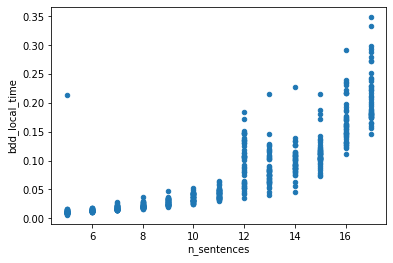

In [6]:
# simple plot

# if you see an outlier at n=5, create a new dataframe and rerun the processes, or remove it manually 
# (numba JIT compilation takes more time upon first call)

df.plot.scatter("n_sentences", "bdd_local_time")